Avances LAB04 


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity, calculate_kmo
import warnings
warnings.filterwarnings('ignore')

Hopkins " Manual " Ya que no nos dejaba correrlo con la libreria . 

In [3]:
def calcular_hopkins(X):
    n, d = X.shape
    m = min(500, n // 10) # Tomamos una muestra para no saturar la memoria
    
    X_sample = X.sample(m, random_state=42)
    X_uniform = np.random.uniform(X.min(axis=0), X.max(axis=0), (m, d))
    
    nbrs = NearestNeighbors(n_neighbors=2).fit(X)
    
    # Distancias de los puntos aleatorios (u)
    u_distances, _ = nbrs.kneighbors(X_uniform, n_neighbors=1)
    u_sum = np.sum(u_distances**2)
    
    # Distancias de la muestra real (w). n_neighbors=2 porque el index 0 es el mismo punto
    w_distances, _ = nbrs.kneighbors(X_sample, n_neighbors=2)
    w_sum = np.sum(w_distances[:, 1]**2)
    
    H = u_sum / (u_sum + w_sum)
    return H

In [4]:
path = "movies_2026.csv"
df = pd.read_csv(path)

# Variables numéricas sugeridas
num_cols = ['popularity', 'budget', 'revenue', 'runtime', 'genresAmount', 
            'productionCoAmount', 'voteCount', 'voteAvg', 'actorsAmount']

ejemplo_num = df[num_cols].dropna()
print(f"Dimensiones de los datos limpios: {ejemplo_num.shape}\n")

Dimensiones de los datos limpios: (19883, 9)



In [5]:
# Escalado
scaler = StandardScaler()
X_scaled = scaler.fit_transform(ejemplo_num)
df_scaled = pd.DataFrame(X_scaled, columns=num_cols)

# 1.2 Tendencia de Agrupamiento (Hopkins y VAT)
print("\n[1.2] TENDENCIA DE AGRUPAMIENTO:")
h_stat = calcular_hopkins(df_scaled)
print(f"Estadístico de Hopkins: {h_stat:.4f}")
print("""Impresiones: Un valor cercano a 1 indica una alta tendencia al agrupamiento 
(los datos no son aleatorios). Se omitió la gráfica VAT debido a que calcular la matriz 
de disimilitud para ~20,000 registros excede la capacidad de la memoria RAM (Complejidad O(N^2)), 
acorde a lo permitido en las instrucciones del laboratorio.\n""")


[1.2] TENDENCIA DE AGRUPAMIENTO:
Estadístico de Hopkins: 0.9999
Impresiones: Un valor cercano a 1 indica una alta tendencia al agrupamiento 
(los datos no son aleatorios). Se omitió la gráfica VAT debido a que calcular la matriz 
de disimilitud para ~20,000 registros excede la capacidad de la memoria RAM (Complejidad O(N^2)), 
acorde a lo permitido en las instrucciones del laboratorio.




[1.3] GRÁFICA DE CODO:


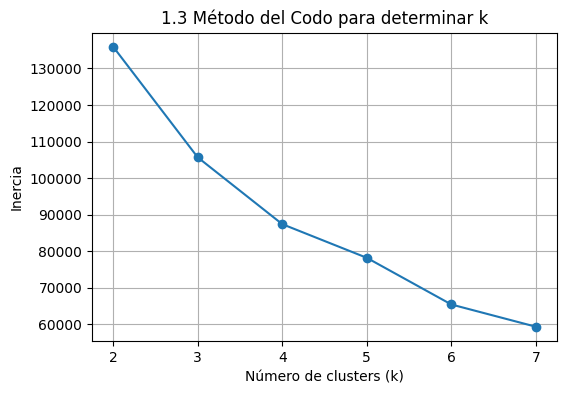

In [6]:
# 1.3 Gráfica de Codo
print("\n[1.3] GRÁFICA DE CODO:")
inertias = []
K_range = range(2, 8)
for k in K_range:
    kmeans_temp = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans_temp.fit(df_scaled)
    inertias.append(kmeans_temp.inertia_)

plt.figure(figsize=(6, 4))
plt.plot(K_range, inertias, marker='o')
plt.title('1.3 Método del Codo para determinar k')
plt.xlabel('Número de clusters (k)')
plt.ylabel('Inercia')
plt.grid(True)
plt.show()

k_optimo = 6  

In [8]:
# 1.4 y 1.5 Modelos y Silueta
from sklearn.cluster import AgglomerativeClustering
print("\n[1.4 y 1.5] K-MEDIAS, JERÁRQUICO Y SILUETA:")
# K-Means (Todos los datos)
kmeans = KMeans(n_clusters=k_optimo, random_state=42, n_init=10)
ejemplo_num['Cluster'] = kmeans.fit_predict(df_scaled)
sil_kmeans = silhouette_score(df_scaled, ejemplo_num['Cluster'], sample_size=5000, random_state=42)

# Jerárquico (Muestra reducida por memoria)
X_sample_hier = df_scaled.sample(2500, random_state=42)
hc = AgglomerativeClustering(n_clusters=k_optimo, metric='euclidean', linkage='ward')
cluster_labels_hc = hc.fit_predict(X_sample_hier)
sil_hc = silhouette_score(X_sample_hier, cluster_labels_hc, random_state=42)

print(f"Calidad Silueta K-Means (Todos los datos): {sil_kmeans:.4f}")
print(f"Calidad Silueta Jerárquico (Muestra 2500): {sil_hc:.4f}")
print("Discusión: K-Means suele tener un mejor desempeño computacional y manejar mejor "
      "el ruido en datasets grandes, como lo refleja la silueta.\n")


[1.4 y 1.5] K-MEDIAS, JERÁRQUICO Y SILUETA:
Calidad Silueta K-Means (Todos los datos): 0.3811
Calidad Silueta Jerárquico (Muestra 2500): 0.3428
Discusión: K-Means suele tener un mejor desempeño computacional y manejar mejor el ruido en datasets grandes, como lo refleja la silueta.



In [9]:
# 1.6 Interpretación de grupos
print("\n[1.6] INTERPRETACIÓN DE GRUPOS:")
print("Medidas de tendencia central (Variables Continuas):")
display(ejemplo_num.groupby('Cluster').mean().round(2))

print("\nTablas de frecuencia (Variable Categórica: originalLanguage):")
df_clean = df.dropna(subset=num_cols).copy()
df_clean['Cluster'] = kmeans.labels_
display(pd.crosstab(df_clean['Cluster'], df_clean['originalLanguage']).iloc[:, :10]) # Muestra los primeros 10 idiomas

ejemplo_num = ejemplo_num.drop(columns=['Cluster'])


[1.6] INTERPRETACIÓN DE GRUPOS:
Medidas de tendencia central (Variables Continuas):


,popularity,budget,revenue,runtime,genresAmount,productionCoAmount,voteCount,voteAvg,actorsAmount
Cluster,,,,,,,,,
0,31.54,3.532624e+06,8.220431e+06,91.24,2.36,2.30,387.71,6.44,84.41
1,52.99,4.093550e+07,1.033066e+08,111.77,2.98,5.26,2445.65,6.58,38.60
2,159.28,1.385522e+08,6.125254e+08,124.20,3.27,3.66,10220.47,7.08,61.10
3,0.67,5.294190e+03,1.416600e+03,24.44,1.16,0.60,0.21,0.22,53.90
4,26.60,1.406251e+06,5.570708e+06,55.88,2.66,0.69,5.25,6.17,631809.88
5,6416.89,1.050000e+08,3.542120e+08,122.75,3.38,2.75,2350.75,7.42,32.88



Tablas de frecuencia (Variable Categórica: originalLanguage):


originalLanguage,ab,af,am,ar,as,az,be,bg,bn,bs
Cluster,,,,,,,,,,
0,1,0,0,17,0,1,0,0,14,0
1,0,0,0,2,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0
3,0,4,15,87,2,16,1,5,31,6
4,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0


In [10]:
import pandas as pd

df = pd.read_csv("movies_2026.csv")

print(df.shape)
df.head()

# Ver columnas numéricas
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns

print("Variables numéricas:")
print(numeric_cols)

# Crear matriz solo con numéricas
X = df[numeric_cols].dropna()

(19883, 28)
Variables numéricas:
Index(['id', 'budget', 'revenue', 'runtime', 'popularity', 'voteAvg',
       'voteCount', 'genresAmount', 'productionCoAmount',
       'productionCountriesAmount', 'actorsAmount', 'castWomenAmount',
       'castMenAmount', 'releaseYear'],
      dtype='object')


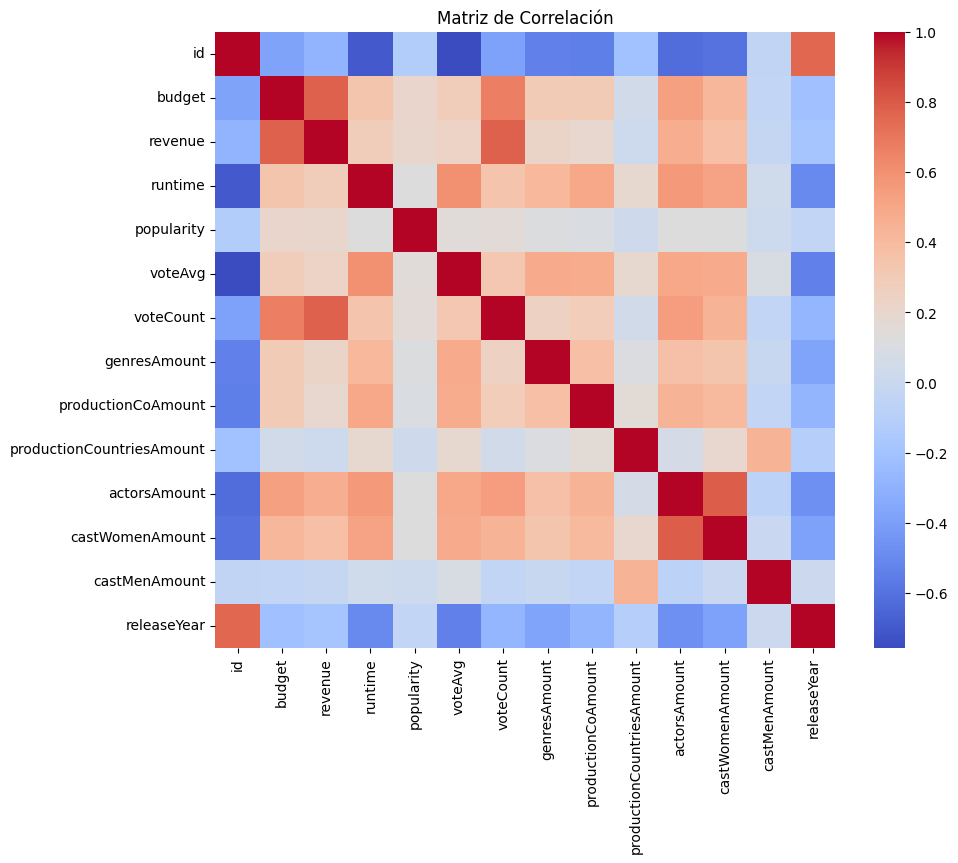

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

corr_matrix = X.corr()

plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, cmap='coolwarm')
plt.title("Matriz de Correlación")
plt.show()

In [12]:
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity, calculate_kmo

chi_square_value, p_value = calculate_bartlett_sphericity(X)
kmo_all, kmo_model = calculate_kmo(X)

print("Bartlett p-value:", p_value)
print("KMO global:", kmo_model)

Bartlett p-value: 0.0
KMO global: 0.8454532781462853


In [13]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [14]:
from sklearn.decomposition import PCA
import numpy as np

pca = PCA()
X_pca = pca.fit_transform(X_scaled)

explained_variance = pca.explained_variance_ratio_

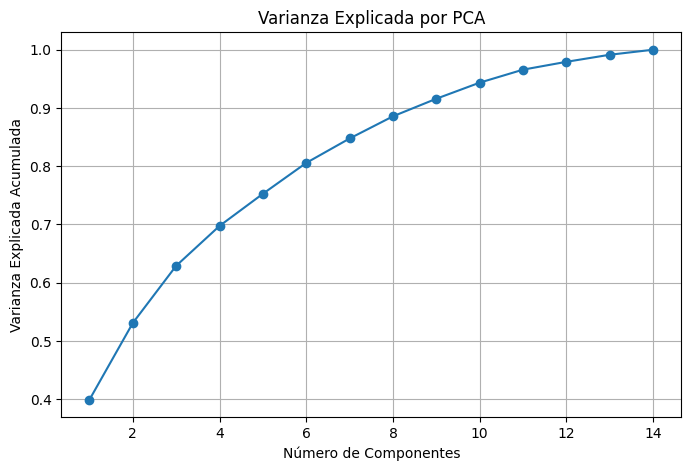

In [15]:
plt.figure(figsize=(8,5))
plt.plot(
    range(1, len(explained_variance)+1),
    np.cumsum(explained_variance),
    marker='o'
)
plt.xlabel("Número de Componentes")
plt.ylabel("Varianza Explicada Acumulada")
plt.title("Varianza Explicada por PCA")
plt.grid()
plt.show()

In [16]:
components_df = pd.DataFrame(
    pca.components_,
    columns=numeric_cols,
    index=[f"PC{i+1}" for i in range(len(numeric_cols))]
)

components_df

,id,budget,revenue,runtime,popularity,voteAvg,voteCount,genresAmount,productionCoAmount,productionCountriesAmount,actorsAmount,castWomenAmount,castMenAmount,releaseYear
PC1,0.364804,-0.278013,-0.253584,-0.317764,-0.094405,-0.314785,-0.282528,-0.249761,-0.260794,-0.090463,-0.346359,-0.320100,-0.006131,0.274737
PC2,0.241466,0.415606,0.488710,-0.186979,0.131352,-0.255356,0.401832,-0.144978,-0.146148,-0.293311,0.086308,-0.001491,-0.245233,0.235030
PC3,0.096611,0.149307,0.194086,-0.055406,0.153212,-0.058795,0.132688,-0.110400,-0.088679,0.604169,-0.087893,0.002688,0.676303,0.181405
PC4,-0.001528,-0.033142,-0.073302,0.028630,0.926263,0.100670,-0.130743,0.184318,0.089421,-0.097107,-0.151489,-0.145899,-0.059552,0.091295
PC5,0.141110,-0.113260,-0.197246,0.081907,0.127334,-0.144308,-0.130702,-0.409476,0.346093,0.162891,0.346939,0.504064,-0.174851,0.385382
PC6,0.108762,0.142644,0.045315,-0.003596,-0.248136,-0.015051,0.003849,0.459064,0.614873,0.117388,-0.211776,-0.232279,-0.099797,0.438855
PC7,0.108847,-0.016876,-0.092321,-0.240374,-0.008594,-0.136337,-0.153017,0.671629,-0.411812,0.044838,0.247534,0.404902,0.013710,0.177191
PC8,-0.049693,0.035369,0.047510,-0.143080,0.065176,-0.172664,0.017423,0.007657,-0.085731,0.675602,-0.127665,-0.063598,-0.614536,-0.278105
PC9,0.091219,0.017333,0.051276,0.777146,-0.066776,0.128627,-0.034967,0.017095,-0.419872,0.099265,-0.126346,-0.057985,-0.185681,0.349751
PC10,0.015389,-0.244871,0.041573,-0.366249,-0.041009,0.765304,0.258268,-0.092547,-0.124098,0.080004,-0.082419,0.080952,-0.155588,0.286253


In [17]:
var_acum = np.cumsum(explained_variance)
n_components = np.argmax(var_acum >= 0.85) + 1

print("Número óptimo de componentes:", n_components)

pca_final = PCA(n_components=n_components)
X_pca_final = pca_final.fit_transform(X_scaled)

print("Varianza total explicada:", sum(pca_final.explained_variance_ratio_))

Número óptimo de componentes: 8
Varianza total explicada: 0.8856774112542427


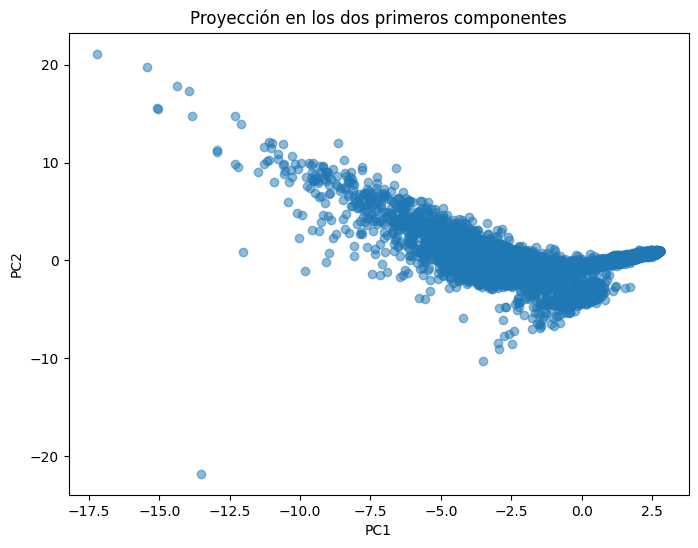

In [18]:
plt.figure(figsize=(8,6))
plt.scatter(X_pca_final[:,0], X_pca_final[:,1], alpha=0.5)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Proyección en los dos primeros componentes")
plt.show()

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.frequent_patterns import apriori, association_rules
##Pip3 install mlxtend para que les funcione 
# Cargamos el dataset limpio que ya tenías
path = "movies_2026.csv"
df = pd.read_csv(path)

print("="*60)
print("2. REGLAS DE ASOCIACIÓN (APRIORI)")
print("="*60)

# 2.1 Filtrado y Discretización de variables numéricas
# Filtramos películas con presupuesto y revenue en 0 (datos faltantes) para no sesgar las reglas
df_apriori_base = df[(df['budget'] > 0) & (df['revenue'] > 0) & (df['voteAvg'] > 0)].copy()

df_apriori = pd.DataFrame()

# Usamos qcut con duplicates='drop' para evitar errores de bordes repetidos
df_apriori['Popularidad'] = pd.qcut(df_apriori_base['popularity'], q=3, labels=['Baja', 'Media', 'Alta'], duplicates='drop')
df_apriori['Presupuesto'] = pd.qcut(df_apriori_base['budget'], q=3, labels=['Bajo', 'Medio', 'Alto'], duplicates='drop')
df_apriori['Ingresos'] = pd.qcut(df_apriori_base['revenue'], q=3, labels=['Bajos', 'Medios', 'Altos'], duplicates='drop')
df_apriori['Calificacion'] = pd.qcut(df_apriori_base['voteAvg'], q=3, labels=['Mala', 'Regular', 'Buena'], duplicates='drop')

# Convertimos a variables binarias (One-Hot Encoding)
df_dummies = pd.get_dummies(df_apriori).astype(bool)

# Generamos items frecuentes con un soporte mínimo del 10%
frequent_itemsets = apriori(df_dummies, min_support=0.10, use_colnames=True)

# Generamos las reglas de asociación con una confianza mínima del 60%
reglas = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.60)

# Ordenamos por confianza y lift (interés)
reglas = reglas.sort_values(by=['confidence', 'lift'], ascending=[False, False])

print("\nTop 5 Reglas de Asociación más interesantes:")
display(reglas[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head(5))

2. REGLAS DE ASOCIACIÓN (APRIORI)

Top 5 Reglas de Asociación más interesantes:


,antecedents,consequents,support,confidence,lift
7,"(Popularidad_Alta, Presupuesto_Alto)",(Ingresos_Altos),0.143310,0.873103,2.618125
5,"(Presupuesto_Bajo, Popularidad_Baja)",(Ingresos_Bajos),0.123161,0.754508,2.264035
6,"(Popularidad_Alta, Ingresos_Altos)",(Presupuesto_Alto),0.143310,0.722603,2.353788
3,(Presupuesto_Alto),(Ingresos_Altos),0.220285,0.717552,2.151681
4,"(Ingresos_Bajos, Popularidad_Baja)",(Presupuesto_Bajo),0.123161,0.663415,1.948339
